https://huggingface.co/docs/transformers/tasks/sequence_classification

# Code Vulnerability Classification using LLMS

**References**

Joshi, P. (2022., June 20). Fine-tuning BERT for spam classification. Github.
https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Import libraries

In [ ]:
! pip install transformers torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.3 MB/s eta 0:00:00


In [ ]:
SEED = 2023


# Import libraries
import numpy as np
import pandas as pd
import re
from pprint import pprint

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizerFast, pipeline
from transformers import AdamW

print(f"transformers {transformers.__version__}")
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
torch.manual_seed(SEED)
# specify GPU
device = torch.device("cuda")
print(f"torch {torch.__version__}")



transformers 4.34.0
torch 2.0.1+cu118


# 2 Load data
Download data from https://www.kaggle.com/datasets/girish17019/cvefixes-vulnerable-and-fixed-code

In [ ]:
# load dataset
data = pd.read_csv('/data/CVEFixes.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31194 entries, 0 to 31193
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      31160 non-null  object
 1   language  31194 non-null  object
 2   safety    31194 non-null  object
dtypes: object(3)
memory usage: 731.2+ KB
None


In [ ]:
# drop nulls
data.dropna(inplace = True)

# Change target labels in safety column to 1 = vulnerable and 0 = safe
label2id = {'vulnerable':1, 'safe':0}
id2label = {1:'vulnerable', 0:'safe'}
data.loc[:,'safety'] = data['safety'].apply(lambda x:label2id[x])

# Change code to from object to string
data.loc[:,'code'] = data['code'].apply(lambda x: str(x))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31160 entries, 0 to 31193
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      31160 non-null  object
 1   language  31160 non-null  object
 2   safety    31160 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 973.8+ KB


<ipython-input-5-a01c4f3a0cea>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'safety'] = data['safety'].apply(lambda x:label2id[x])


## 2.1 Exploratory Data Analysis

In [ ]:
# Length of code (number of characters)
data['length'] = data['code'].apply(lambda x: len(x))

max_char = max(data['length'])
print(f"Max number of characters: {max_char}")

data = data.drop(columns=['length'])

Max number of characters: 33429210


In [ ]:
# Visualise distribution
viz_df = data.groupby(["language","safety"]).size().reset_index(name="count")
viz_df.loc[:,'safety'] = viz_df['safety'].apply(lambda x:id2label[x])


fig = px.bar(viz_df, x="safety", y="count", color="safety", facet_col="language",
             facet_col_wrap=6,
             height = 1000)
fig.show()

In [ ]:
# Visualise the distribution for the top N lanaguages
TOP_N = 10

# Get the top N languages
top_lang = data.groupby(["language"]).size().reset_index(name="count")
top_lang = top_lang.sort_values('count', ascending = False)
top_lang = top_lang['language'][:TOP_N].tolist()

# Visualise distribution
viz_df = data.groupby(["language","safety"]).size().reset_index(name="count")
viz_df.loc[:,'safety'] = viz_df['safety'].apply(lambda x:id2label[x])

viz_df = viz_df.loc[viz_df['language'].isin(top_lang)]


fig = px.bar(viz_df, x="safety", y="count", color="safety", facet_col="language",
             facet_col_wrap=5,
             title = 'Top 10 lanagauges',
             height = 500)
fig.show()


## 2.2 Data preprocessing

In [ ]:
# for Python


# remove comments beginning with # or within ''' '''
def remove_comments(code):
    return re.sub(r'#.*|(\'\'\'|\"\"\")[^\'\"]*(\'\'\'|\"\"\")', '', code)
    # return re.sub(r'#.*|\'\'\'[^\'\']*\'\'\'', '', code)

# check if there are multiple '\n' and combine them into one '\n'
def combine_newlines(code):
    return re.sub(r'\n+', '\n', code)

# data.loc[:,'code'] = data['code'].apply(lambda x: combine_newlines(remove_comments(x)))
data.loc[:,'code'] = data.apply(lambda row: combine_newlines(remove_comments(row['code'])) if row['language']=='py' else row['code'], axis = 1)

# pprint(data.loc[85,'code'])

In [ ]:
# for C

# remove comments beginning with # or with "/" or "//"
def remove_comments(code):
    return re.sub(r'#.*|(\/\/[^\n]*|\/\*[\s\S]*?\*\/)', '', code)

# check if there are multiple '\n' and combine them into one '\n'
def combine_newlines(code):
    return re.sub(r'\n+', '\n', code)

data.loc[:,'code'] = data.apply(lambda row: combine_newlines(remove_comments(row['code'])) if row['language']=='c' else row['code'], axis = 1)

# Drop rows with 'code' == "404: Not Found"
s = "404: Not Found"
data = data[data['code'] != s]

# pprint(data.loc[3,'code'])



In [ ]:
# Specify which langauge to keep
langauges = ['c','py']

data = data.loc[data['language'].isin(langauges)]

print(data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9989 entries, 2 to 31192
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      9989 non-null   object
 1   language  9989 non-null   object
 2   safety    9989 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 312.2+ KB
None


In [ ]:
# Count number of characters

data["num_chars"]=data['code'].apply(lambda x: len(x.split()))

fig = px.histogram(data, x="num_chars", color="safety",
                   title="Number of documents by number of characters")
fig.show()

In [ ]:
# Keep rows with 512 or fewer characters
MAX_SEQ_LENGTH = 512


data = data[data["num_chars"]<= MAX_SEQ_LENGTH]

data.head(5)

,code,language,safety,num_chars
2,"\nfrom __future__ import division, absolute_im...",py,0,116
3,\nstatic VCHANNEL *cliprdr_channel;\nstatic ui...,c,0,300
89,\nstatic VCHANNEL *lspci_channel;\ntypedef str...,c,0,340
123,\nstatic void sasl_timeout_callback(struct Eve...,c,1,296
130,\nfrom __future__ import absolute_import\nfrom...,py,0,71


## 2.3 Train-test split

In [ ]:
# Split into train and test sets 80:20
X_train, X_tmp, y_train, y_tmp = train_test_split(data['code'], data['safety'],
                                                    test_size = 0.2,
                                                    random_state = SEED,
                                                    stratify = data['safety']
                                                    )

X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp,
                                                test_size = 0.5,
                                                random_state = SEED,
                                                stratify = y_tmp
                                                )

print(f"training set: {len(X_train)}")
print(f"validation set: {len(X_val)}")
print(f"test set: {len(X_test)}")


training set: 1119
validation set: 140
test set: 140


# 3 CodeBERT
CodeBERT is a multi-programming-lingual model pre-trained on NL-PL pairs in 6 programming languages (Python, Java, JavaScript, PHP, Ruby, Go).

In [ ]:
BATCH_SIZE = 8

In [ ]:
# Instantiate model
codebert = AutoModel.from_pretrained("microsoft/codebert-base")

# # Freeze params
# for param in codebert.parameters():
#     param.requires_grad = False

# Instantiate tokenizer
codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")


### 3.1 Tokenize and convert to tensors

In [ ]:
def tokenize_tensorize(X_array, y_array, tokenizer):
  # Tokenize
  tokenized = tokenizer.batch_encode_plus(X_array.tolist(),
                                          max_length = MAX_SEQ_LENGTH,
                                          padding="longest",
                                          truncation=True,
                                          return_token_type_ids=False
                                          )

  # Convert to tensors
  seq = torch.tensor(tokenized['input_ids'])
  mask = torch.tensor(tokenized['attention_mask'])
  y = torch.tensor(y_array.tolist())

  return seq, mask, y

def make_dataloader(X_array, y_array, tokenizer, batch_size):
  seq, mask, y = tokenize_tensorize(X_array, y_array, tokenizer)

  # Create DataLoaders
  tensor_dataset = TensorDataset(seq, mask, y)  # wrap tensors
  sampler = RandomSampler(tensor_dataset)       # sampler for sampling the data during training
  dataloader = DataLoader(tensor_dataset, sampler=sampler, batch_size=batch_size)

  return dataloader


# Make dataloaders for traning and validation sets
train_dataloader = make_dataloader(X_train, y_train, codebert_tokenizer, batch_size=BATCH_SIZE)
val_dataloader = make_dataloader(X_val, y_val, codebert_tokenizer, batch_size=BATCH_SIZE)

# Convert test set to tensors
test_seq, test_mask, test_y = tokenize_tensorize(X_test, y_test, codebert_tokenizer)

### 3.2 Compute class weights

In [ ]:
# compute the class weights
class_wts = compute_class_weight(class_weight ='balanced', classes = np.unique(y_train), y = y_train)

print(class_wts)


# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

[0.94991511 1.05566038]


### 3.3 Model architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, codebert):

      super(BERT_Arch, self).__init__()

      self.bert = codebert

      # Dropout layer
      self.dropout = nn.Dropout(0.2)

      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,MAX_SEQ_LENGTH)

      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(MAX_SEQ_LENGTH,1) # 1 for binary classification

      # Softmax activation
      # self.softmax = nn.LogSoftmax(dim=1)
      self.sigmoid = nn.Sigmoid()

    # Forward pass
    def forward(self, sent_id, mask):

      # Pass inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)

      # Apply softmax activation
      # x = self.softmax(x)
      x = self.sigmoid(x)

      return x

## 3.4 Helper functions for training

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, weight_fn=1.0, weight_fp=1.0):
        super(CustomLoss, self).__init__()
        self.weight_fn = weight_fn  # Weight for false negatives
        self.weight_fp = weight_fp  # Weight for false positives
        self.loss_fn = nn.BCELoss()  # You can use Binary Cross-Entropy Loss as the base loss function

    def forward(self, predictions, targets):
        # Calculate the base loss using BCELoss
        base_loss = self.loss_fn(predictions, targets)

        # Calculate the number of true positives, false negatives, and false positives
        tp = ((predictions >= 0.5) & (targets == 1)).sum()
        fn = ((predictions < 0.5) & (targets == 1)).sum() # WORST
        fp = ((predictions >= 0.5) & (targets == 0)).sum() # BAD

        # Calculate the custom loss with weighted penalties
        custom_loss = base_loss + self.weight_fn * fn + self.weight_fp * fp

        return custom_loss

In [ ]:
# Helper function for model training
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # Empty list to save model predictions
  total_preds=[]

  # Iterate over batches
  for step,batch in enumerate(train_dataloader):

    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # Convert the labels to the same dtype as the predictions (float), for binary classification
    labels = labels.float()

    # Clear previously calculated gradients
    model.zero_grad()

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = binary_cross_entropy(preds, labels.unsqueeze(1))

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Append the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # Prediction format: (no. of batches, size of batch, no. of classes).
  # Reshape the predictions to: (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Return the average loss and predictions
  return avg_loss, total_preds

In [ ]:
# Helper function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # Create list for model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0) # Elaspsed time in mins
      print(f'  Batch {step:>5,}  of  {len(val_dataloader):>5,}.')

    # Push the batch to GPU
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch


    # Convert the labels to the same dtype as the predictions (float), for binary classification
    labels = labels.float()


    # Deactivate autograd
    with torch.no_grad():

      # Model predictions
      preds = model(sent_id, mask)

      # Convert labels to [batch_size, 1]
      labels = labels.view(-1, 1)

      # Compute the validation loss between actual and predicted values
      loss = binary_cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## 3.5 Train model

In [ ]:
# Empty cache to free up space
torch.cuda.empty_cache()

In [ ]:
# Pass the pre-trained BERT to our defined architecture
model = BERT_Arch(codebert)

# Push the model to GPU
model = model.to(device)

# Training epochs
EPOCHS = 10

# Optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Loss function
# cross_entropy  = nn.NLLLoss(weight=weights) # for multiclass
# binary_cross_entropy = nn.BCELoss() # for binary class
# binary_cross_entropy = CustomLoss(weight_fn=10.0, weight_fp=2.0) # all vul
# binary_cross_entropy = CustomLoss(weight_fn=3.0, weight_fp=1.5) # all vul with batch = 8
binary_cross_entropy = CustomLoss(weight_fn=1.5, weight_fp=1) # all vul with batch = 8


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [ ]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))

    # Train model
    train_loss, _ = train()

    # Evaluate model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.563
Validation Loss: 6.194

 Epoch 2 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.871
Validation Loss: 4.809

 Epoch 3 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.769
Validation Loss: 4.930

 Epoch 4 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.673
Validation Loss: 6.206

 Epoch 5 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.894
Validation Loss: 6.199

 Epoch 6 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 6.485
Validation Loss: 6.192

 Epoch 7 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.830
Validation Loss: 6.202

 Epoch 8 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 5.878
Validat

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## 3.6 Predict

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.47      1.00      0.64        66

    accuracy                           0.47       140
   macro avg       0.24      0.50      0.32       140
weighted avg       0.22      0.47      0.30       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



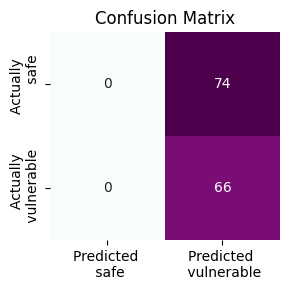

In [ ]:
# Predict on test data
with torch.no_grad():
  y_pred = model(test_seq.to(device), test_mask.to(device))
  y_pred = y_pred.detach().cpu().numpy()
# print(y_pred)

# Output predicted labels
y_pred = [1 if x>0.5 else 0 for x in y_pred] # for binary class
# y_pred = np.argmax(y_pred, axis = 1) # for multiclass
print(classification_report(y_test, y_pred))

def show_cm(y_actual, y_pred):
  # Visualise confusion matrix
  fig, ax = plt.subplots(figsize=(3,3))
  cm = confusion_matrix(y_actual, y_pred)
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="BuPu", cbar=False)
  plt.title('Confusion Matrix')
  #plt.xlabel('Predicted label')
  ax.set_xticklabels(["Predicted \n safe","Predicted \n vulnerable"])
  #plt.ylabel('True label')
  ax.set_yticklabels(["Actually \n safe","Actually \n vulnerable"])
  plt.tight_layout()
  plt.show()


show_cm(test_y, y_pred)